# project

In [2]:
# Import the full met.ie dataset (downloaded from https://www.met.ie/climate/available-data/historical-data)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import *
import numpy as np
import math


In [3]:
# Some function definitions
# Returns a season designation based on month to a dataframe 
def split_seasons(df_to_split, months):
  season_df = pd.DataFrame()
  for month in months:
    month_loc = df_to_split['datetime'].dt.month.between(month, month)
    season_df = pd.concat([season_df, df_to_split.loc[month_loc]])
  return season_df

# Returns Pearsons correlation on dataframe
def get_corr(data):
    return data.corr()

# assigns a season class to the data to allow for referencing of data without splitting dataframe
def assign_season_class(the_data, the_class, months):
  for month in months:
    month_loc = the_data['datetime'].dt.month.between(month, month)
    the_data.loc[month_loc, 'season'] = the_class
  return the_data

# function to find the midpoints of a array of bins
def mean_bins(given_bins):
  bins = []
  for i in range(len(given_bins[:-1])):
    bins.append((given_bins[i]+given_bins[i+1])/2)
  return np.array(bins)

# Define a styler for tables 
def my_styler(df, precision, caption):
    df_styler = df.style.format(precision=precision).set_caption(caption)
    return df_styler 

# Highlights values in a table between left and right values. Returns a styler object that can be displayed
def styler_highlight_between(df_styler, left, right):
    print(f"{left} {right}")
    df_styler = df_styler.highlight_between(color="#fffd75", left=left, right=right, inclusive='both') 
    return df_styler
  

In [4]:
# Read in the datafile
all_data_df = pd.read_csv("data/Athenry_met/hly1875.csv", skiprows=17)


In [5]:
all_data_df.columns.values

array(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir'],
      dtype=object)

In [6]:
# set index to be datetime
all_data_df['datetime'] = pd.to_datetime(all_data_df['date'])
all_data_df = all_data_df.set_index(all_data_df['datetime'])
all_data_df.drop(columns=['date'], inplace=True)

In [7]:
# Taking the data since 2015 to end 2022
time_start = "2015-01-01 00:00:00"
time_end = "2022-12-31 23:00:00"
# data_df is the time period to analyse
data_df = all_data_df.loc[time_start : time_end].copy()
data_df


,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir,datetime
datetime,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0,0.0,0,8.3,0,7.2,5.9,9.3,84,1019.7,2,9,2,210,2015-01-01 00:00:00
2015-01-01 01:00:00,0,0.0,0,8.3,0,7.2,5.8,9.2,84,1019.5,2,10,2,200,2015-01-01 01:00:00
2015-01-01 02:00:00,0,0.0,0,8.2,0,7.1,5.8,9.2,84,1018.8,2,10,2,210,2015-01-01 02:00:00
2015-01-01 03:00:00,0,0.0,0,9.3,0,7.7,5.7,9.2,78,1018.1,2,11,2,200,2015-01-01 03:00:00
2015-01-01 04:00:00,0,0.0,0,9.6,0,8.3,6.7,9.8,81,1016.6,2,9,2,200,2015-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0,0.0,0,4.4,0,4.2,4.0,8.1,96,992.9,2,3,2,40,2022-12-31 19:00:00
2022-12-31 20:00:00,0,0.0,0,4.5,0,4.3,4.1,8.2,97,993.4,2,1,2,50,2022-12-31 20:00:00
2022-12-31 21:00:00,0,0.0,0,4.6,0,4.4,4.2,8.2,96,994.0,2,3,2,30,2022-12-31 21:00:00


In [8]:
# Some initial data investigation
# replace blankspace with nan - https://stackoverflow.com/questions/13445241/replacing-blank-values-white-space-with-nan-in-pandas
data_df = data_df.replace(r'^\s+$', np.nan, regex=True)


In [9]:
# Take 4 met variables - hourly rainfall, temperature, sealevel pressure and relative humidity
# convert the 4 chosen variables to float types
data_df[['rain', 'temp', 'msl', 'rhum', 'wddir', 'wdsp']] = data_df[['rain', 'temp', 'msl', 'rhum', 'wddir', 'wdsp']].astype(float)
# create a smaller dataframe
mydata_df = data_df[['rain', 'temp', 'msl', 'wddir', 'rhum', 'wdsp', 'datetime']].copy()


# Plots of 8 years of hourly met data at Athenry weather station (2015-2022)
- Histogram of data for rainfall is highly skewed towards 0, i.e., there are many hours where there is no rain
- Histogram of temperature appears to be normally distributed.
- Histogram of pressure similarly appears to be approximately normally distributed with a skew towards lower pressure - requires more research.

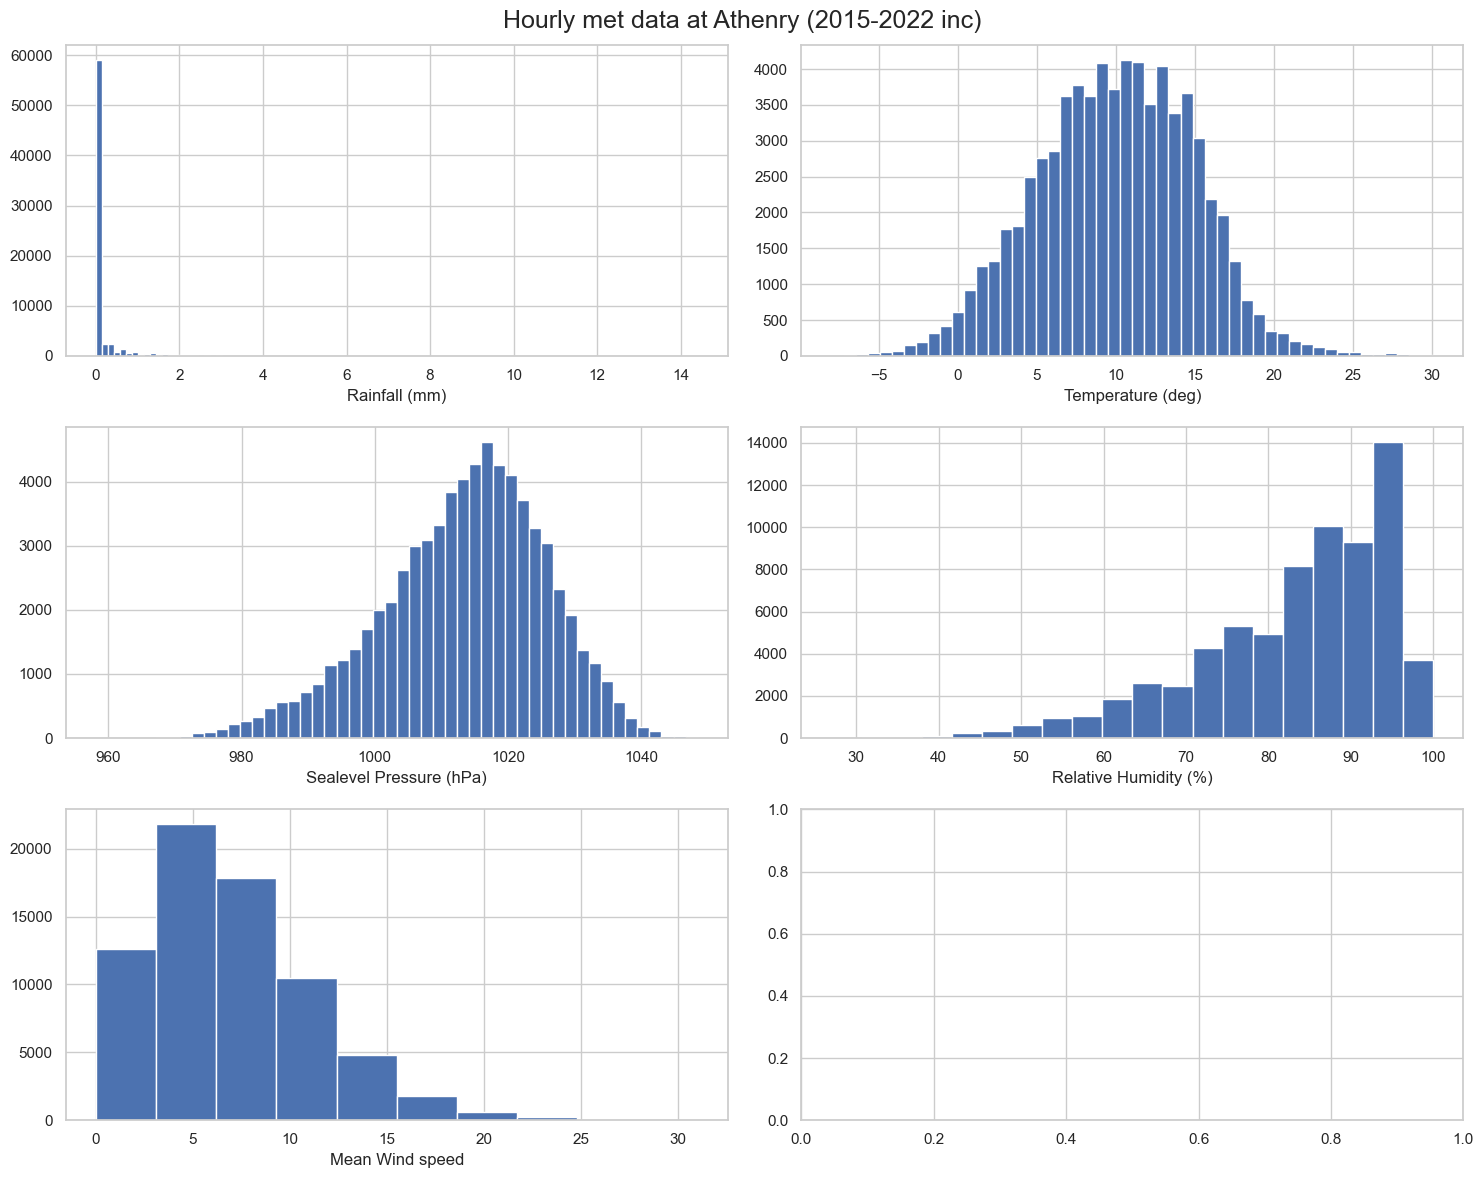

In [21]:
# Plots of the 8 year dataset for the 4 chosen variables
fig, axs = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("Hourly met data at Athenry (2015-2022 inc)", fontsize=18)
axs[0,0].hist(data_df['rain'], bins=100)
axs[0,0].set_xlabel('Rainfall (mm)', fontsize=12)
axs[0,1].hist(data_df['temp'], bins=50)
axs[0,1].set_xlabel('Temperature (deg)', fontsize=12)
axs[1,0].hist(data_df['msl'], bins=50)
axs[1,0].set_xlabel('Sealevel Pressure (hPa)', fontsize=12)
axs[1,1].hist(data_df['rhum'], bins=20)
axs[1,1].set_xlabel('Relative Humidity (%)', fontsize=12)
axs[2,0].hist(data_df['wdsp'], bins=10)
axs[2,0].set_xlabel('Mean Wind speed', fontsize=12)


#labels = np.arange(0, 370, 10).tolist()
#wind_dict = {}
#for key in labels:
#  wind_dict[key] = data_df['wddir'].reset_index(drop=True).to_list().count(key)
#axs[1,1].bar(range(len(labels)), wind_dict.values())
#axs[1,1].set_xlabel('Wind direction (deg)', fontsize=12)

plt.tight_layout()
plt.show()


Daily aggregation of the data gives a daily snapshot of the weather. A correlation table shows highest correlation to be between between atmospheric pressure (msl) and rainfall amounts (-0.45).

As weather is seasonal, a seasonal correlation between these 4 variables would perhaps be more meaningful.

In [33]:
# Aggregate the data based on daily mean or sum (in the case of rainfall)
mydata_agg = pd.DataFrame()
mydata_agg['Rainfall sum'] = data_df[['rain', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).sum()
mydata_agg['Temp mean'] = data_df[['temp', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()
mydata_agg['Msl mean'] = data_df[['msl', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()
mydata_agg['rhum mean'] = data_df[['rhum', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).mean()
mydata_agg['wdsp max'] = data_df[['wdsp', 'datetime']].groupby(pd.Grouper(key='datetime', freq='D')).max()

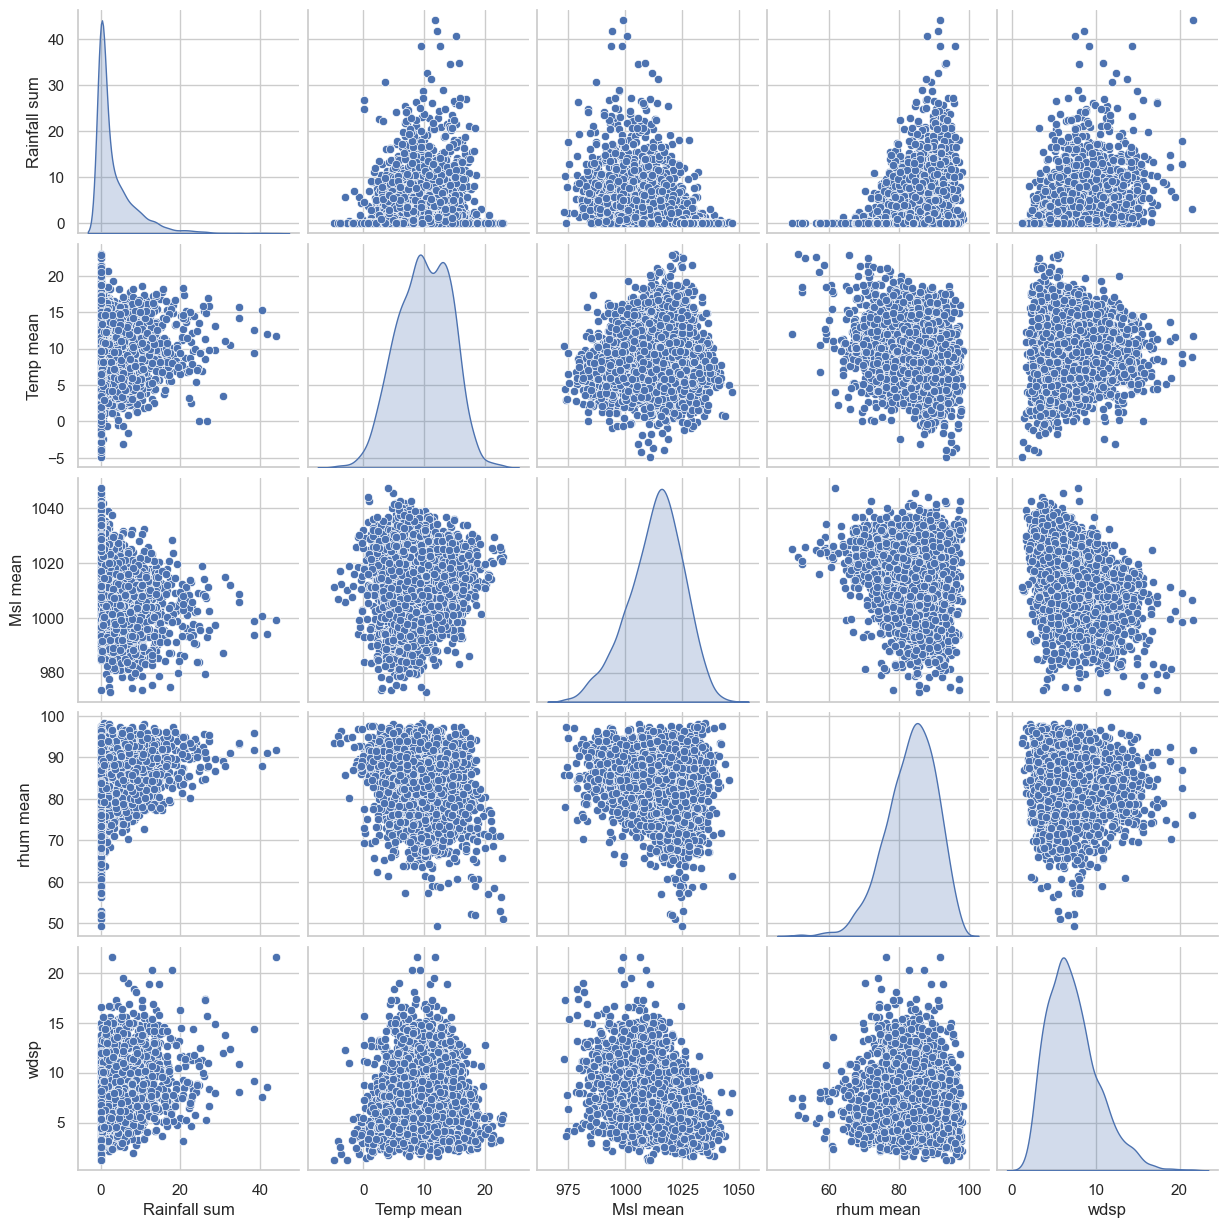

In [12]:
# Create a pairplot of the data
sns.set_theme(style='whitegrid')
g = sns.pairplot(mydata_agg, diag_kind="kde")
#g.map_lower(sns.kdeplot, levels=7, color=".2")
#g.savefig(f"{plots_folder}/scatter_pairplot.png")
plt.show()

## Correlation between meteorological measurements (aggregated)
In order to investigate correlation between the data variables, the data is split into seasons (where meteorological winter is December to February inclusive, and so on). The Pearson correlation method in pandas is applied to the data (by season).

There is no strong correlation between any of the data variables investigated as part of this study. The strongest correlation across all seasons is the negative correlation between rainfall and pressure level which ranges from -0.42 to -0.49 across all seasons.  Correlation values greater or less than 0.3 and -0.3 respecitvley are highlighted in the tables below. 

Spring and summer show more correlation between the meteorological variables than autumn and winter.

In [41]:
# Call a function to split the data and return data based on a season
# Put datetime back as a variable
# https://sparkbyexamples.com/pandas/pandas-set-index-to-column-in-dataframe/
mydata_agg_i = mydata_agg.reset_index()
winter_months = [12, 1, 2]
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
autumn_months = [9, 10, 11]
# assign a new variable "season" to the data
mydata_agg_i['season'] = ''
mydata_agg_i = assign_season_class(mydata_agg_i, 'winter', winter_months)
mydata_agg_i = assign_season_class(mydata_agg_i, 'spring', spring_months)
mydata_agg_i = assign_season_class(mydata_agg_i, 'summer', summer_months)
mydata_agg_i = assign_season_class(mydata_agg_i, 'autumn', autumn_months)

class_names = ['winter', 'spring', 'summer', 'autumn']  # to allow looping over seasons

corr_styler_list = []
#mydata_agg_i.drop(columns = ["season", "datetime"]) 
df_corr =  get_corr(mydata_agg_i.drop(columns = ["season", "datetime"]))    
df_styler = my_styler(df_corr, 2,  "Correlation - all data")
df_styler = styler_highlight_between(df_styler, 0.3, 0.99)
df_styler = styler_highlight_between(df_styler, -0.99, -0.3)
display(df_styler)


# Get correlation matrices for the 4 seasons and display
for i, item in enumerate(class_names):
    # Extract the data related to one season
    season_data = mydata_agg_i[mydata_agg_i["season"] == item].copy()
    # Strip the class column before passing to function
    season_data.drop(columns = ["season", "datetime"], inplace=True) 
    df_corr =  get_corr(season_data)      
    df_styler = my_styler(df_corr, 2, item + " Correlation")
    df_styler = styler_highlight_between(df_styler, 0.3, 0.99)
    df_styler = styler_highlight_between(df_styler, -0.99, -0.3)
    corr_styler_list.append(df_styler)
    
for item in corr_styler_list:
    display(item)



0.3 0.99
-0.99 -0.3


,Rainfall sum,Temp mean,Msl mean,rhum mean,wdsp max
Rainfall sum,1.00,0.02,-0.45,0.35,0.43
Temp mean,0.02,1.00,0.10,-0.18,-0.08
Msl mean,-0.45,0.10,1.00,-0.22,-0.45
rhum mean,0.35,-0.18,-0.22,1.00,-0.02
wdsp max,0.43,-0.08,-0.45,-0.02,1.00


0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3
0.3 0.99
-0.99 -0.3


,Rainfall sum,Temp mean,Msl mean,rhum mean,wdsp max
Rainfall sum,1.00,0.22,-0.45,0.09,0.50
Temp mean,0.22,1.00,-0.00,-0.00,0.39
Msl mean,-0.45,-0.00,1.00,0.04,-0.46
rhum mean,0.09,-0.00,0.04,1.00,-0.41
wdsp max,0.50,0.39,-0.46,-0.41,1.00


,Rainfall sum,Temp mean,Msl mean,rhum mean,wdsp max
Rainfall sum,1.00,-0.11,-0.49,0.46,0.48
Temp mean,-0.11,1.00,0.15,-0.13,-0.19
Msl mean,-0.49,0.15,1.00,-0.32,-0.45
rhum mean,0.46,-0.13,-0.32,1.00,0.15
wdsp max,0.48,-0.19,-0.45,0.15,1.00


,Rainfall sum,Temp mean,Msl mean,rhum mean,wdsp max
Rainfall sum,1.00,-0.05,-0.48,0.50,0.33
Temp mean,-0.05,1.00,0.13,-0.12,-0.23
Msl mean,-0.48,0.13,1.00,-0.37,-0.50
rhum mean,0.50,-0.12,-0.37,1.00,0.17
wdsp max,0.33,-0.23,-0.50,0.17,1.00


,Rainfall sum,Temp mean,Msl mean,rhum mean,wdsp max
Rainfall sum,1.00,0.17,-0.42,0.29,0.43
Temp mean,0.17,1.00,0.01,-0.03,0.15
Msl mean,-0.42,0.01,1.00,-0.13,-0.40
rhum mean,0.29,-0.03,-0.13,1.00,-0.14
wdsp max,0.43,0.15,-0.40,-0.14,1.00


# Rainfall distribution - Analysis and Synthesisation
- Rainfall over a period of time can follow an exponential distribution [https://www.realclimate.org/index.php/archives/2017/11/a-brief-review-of-rainfall-statistics/] when the 0 rainfall periods are removed.
- Taking the daily aggregated data, the frequency of rainy days, fw, is calculated by classifying a "rainy" day as one in which the total rainfall is >1mm.  
- From 8 years of data, the frequency of rainy days is approximately 0.5, i.e., So 1 in 2 days has rainfall overall.
- For the days that are classified as rainy, the mean daily rainfall is 6.7mm
- It is possible to generate data for 1 year to synthesise daily rainfall totals by the following:
    -- generate some random data based on the exponential distribution parameters which describe the rainfall daily total distribution. The size of the random data is based on the frequency of rainy days, fw, multiplied by the total number of days of required data. 
- The number of dry days is found by subtracting rainy days from the total number of days and a value of 0 is assigned.
- The 2 arrays are joined together and then shuffled randomly.
- It would perhaps be more meaningful to find a distribution for each season and generate synthesised data on a season basis.
- The synthesised data when generated for a 1 year period does not accurately capture the probability of having higher values. It would perhaps be better to synthesise a larger set and then 


The exponential distribution:

$$
f(x;\lambda) = 
\begin{cases} 
\lambda e^{-\lambda x} & \text{if } x \geq 0 \\
0 & \text{if } x < 0 
\end{cases}
$$
 
  
 https://stackoverflow.com/questions/2896179/fitting-a-gamma-distribution-with-python-scipy
 - [https://en.wikipedia.org/wiki/Gamma_distribution]
 https://www.geeksforgeeks.org/how-to-do-exponential-and-logarithmic-curve-fitting-in-python/

23


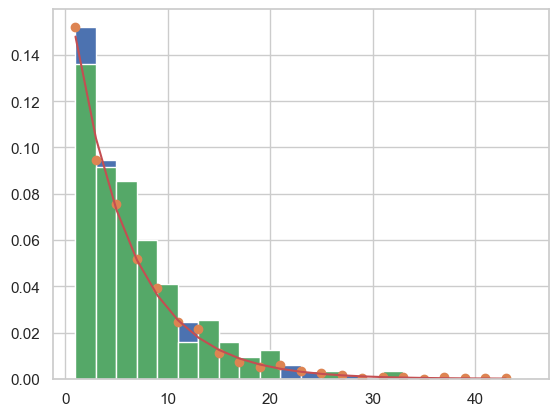

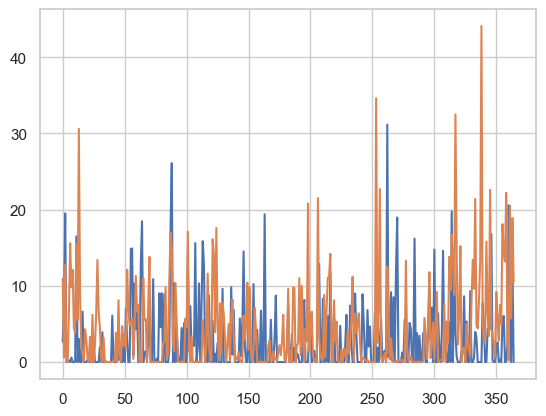

In [14]:
# Do some analysis on the daily aggregated rainfall data over 8 years.

rainfall_df = mydata_agg_i[['Rainfall sum', 'datetime']]
rainfall_df = rainfall_df.set_index('datetime')
max_rain = rainfall_df['Rainfall sum'].max()
min_rain = rainfall_df['Rainfall sum'].min()
# frequency of rainy days with criterion of >1mm rainfall in a day
fw = (rainfall_df['Rainfall sum']>1).sum() / len(rainfall_df)
daily_rain_rainydays = rainfall_df[rainfall_df['Rainfall sum']>1]
bin_size = 2
daily_rain_rainydays_floor = math.floor(daily_rain_rainydays.min())
daily_rain_rainydays_ceiling = math.ceil(daily_rain_rainydays.max())

# returns the normalised data for the histogram (area under curve =1)
bins = np.arange(daily_rain_rainydays_floor, daily_rain_rainydays_ceiling+bin_size, bin_size)
n, bins_returned, patches = plt.hist(daily_rain_rainydays, bins=bins, density=True)
print(len(bins))

# get a list of the midpoints for each bin for curve fitting
bin_mid = []
for i in range(len(bins[:-1])):
  bin_mid.append((bins[i]+bins[i+1])/2)

#bin_mid = np.array(bin_mid)

bin_mid = np.array(bins[:-1])
bin_start = np.array(bins[:-1])

plt.plot(bin_mid, n, 'o')

# Use curve_fit method as in: https://stackoverflow.com/questions/50448199/lognormal-curve-fit
# PDF for the exponential distribution - so that curve fitting can be done
def f_exp(bin_mid, lamda_1):
  return lamda_1*np.exp(-1*lamda_1*bin_mid)

params, extras = curve_fit(f_exp, bin_mid, n)

# fit a exponential curve
lamda_1 = params[0]
pdf_expon = (lamda_1*np.exp(-1*lamda_1*bin_mid))

plt.plot(bin_mid, pdf_expon, 'r')


# set up a random generator for exponential distribution
# https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.exponential.html
# generate 1 year of daily rainfall totals - assuming that the frequency of rainy days calculated above
random_daily_rainfall_1yr = np.random.default_rng().exponential(1/lamda_1, int(365*fw))
plt.hist(random_daily_rainfall_1yr, bins=bins, density=True)
plt.show()

no_rainfall_days = int(fw * 365)
daily_non_rainfall_1yr = np.array((365-no_rainfall_days)*[0])

year_rainfall_syn_data = np.concatenate((random_daily_rainfall_1yr, daily_non_rainfall_1yr))

np.random.shuffle(year_rainfall_syn_data)

plt.plot(year_rainfall_syn_data)
plt.plot(mydata_agg_i['Rainfall sum'][0:365])



# Synthesising Mean Sea Level Pressure (msl)
- From above, the distribution of pressure is skewed to the left.
- From looking at 

- 



Text(0.5, 0, 'Pressure - autumn')

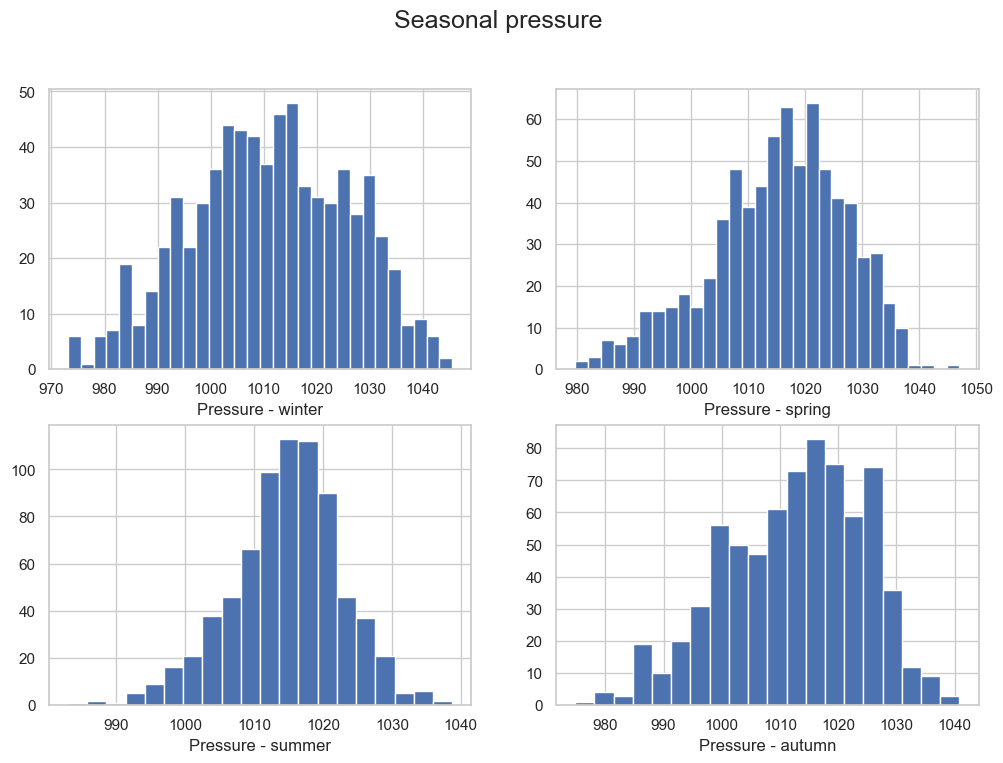

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Seasonal pressure", fontsize=18)
axs[0,0].hist(mydata_agg_i['Msl mean'].loc[mydata_agg_i['season']=="winter"], bins=30)
axs[0,0].set_xlabel('Pressure - winter', fontsize=12)
axs[0,1].hist(mydata_agg_i['Msl mean'].loc[mydata_agg_i['season']=="spring"], bins=30)
axs[0,1].set_xlabel('Pressure - spring', fontsize=12)
axs[1,0].hist(mydata_agg_i['Msl mean'].loc[mydata_agg_i['season']=="summer"], bins=20)
axs[1,0].set_xlabel('Pressure - summer', fontsize=12)
axs[1,1].hist(mydata_agg_i['Msl mean'].loc[mydata_agg_i['season']=="autumn"], bins=20)
axs[1,1].set_xlabel('Pressure - autumn', fontsize=12)



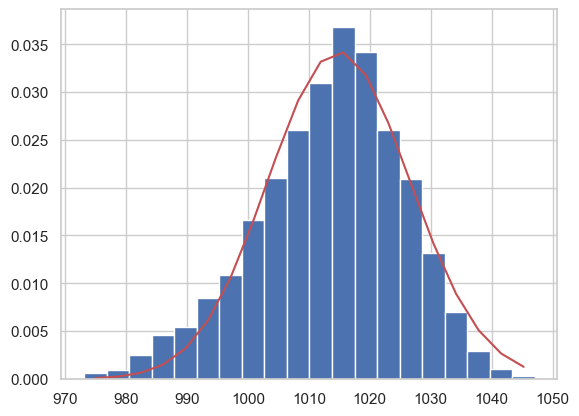

In [16]:
#n, bins_returned, patches = plt.hist(mydata_agg_i['Msl mean'].loc[mydata_agg_i['season']=="summer"], bins=20, density=True)
n, bins_returned, patches = plt.hist(mydata_agg_i['Msl mean'], bins=20, density=True)

bins = mean_bins(bins_returned)
# https://en.wikipedia.org/wiki/Log-normal_distribution
def f_lognormal(x, mu, sigma):
  return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)-mu)**2)/(2*sigma**2))

# returns mu and sigma in params 
params, extras = curve_fit(f_lognormal, bins, n)

mu_pressure = params[0]
sigma_pressure = params[1]
# fit a lognormal curve
pdf_lognormal = f_lognormal(bins, mu_pressure, sigma_pressure)
plt.plot(bins, pdf_lognormal, 'r')
plt.show()


In [17]:
# Synthesise data for msl (pressure)
# https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.lognormal.html
# Generate 1 year of daily mean pressure data
random_daily_pressure_1yr = np.random.default_rng().lognormal(mean=mu_pressure, sigma=sigma_pressure, size = 365)

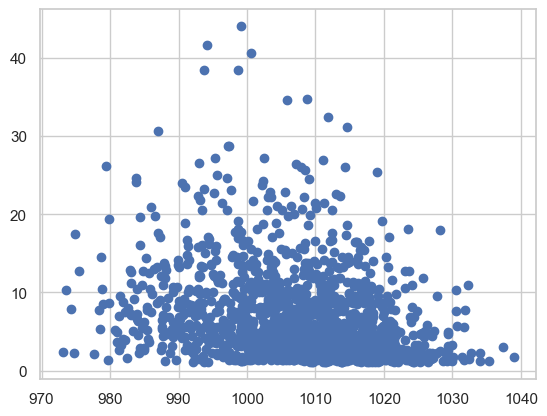

[[ 1.         -0.26111466]
 [-0.26111466  1.        ]]


In [18]:
# Getting the correlation coefficients between the daily mean pressure and the daily rainfall amount for the days that have >1mm rainfall.
plt.scatter(mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], mydata_agg_i['Rainfall sum'].loc[mydata_agg_i['Rainfall sum']>1]);
plt.show()

r = np.corrcoef(mydata_agg_i['Msl mean'].loc[mydata_agg_i['Rainfall sum']>1], mydata_agg_i['Rainfall sum'].loc[mydata_agg_i['Rainfall sum']>1])
print(r)

# Synthesising temperature data
The temperature distribution above shows a broadly normal distribution.  
The synthesised data histogram (for a population of 365 days), shows reasonable quantitative match with the actual data when a random normal distribution is generated.

It would perhaps make sense here to synthesise temperature based on seasons.

### normal pdf

$$ f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \big( \frac{x- \mu}{\sigma} \big)^2} $$

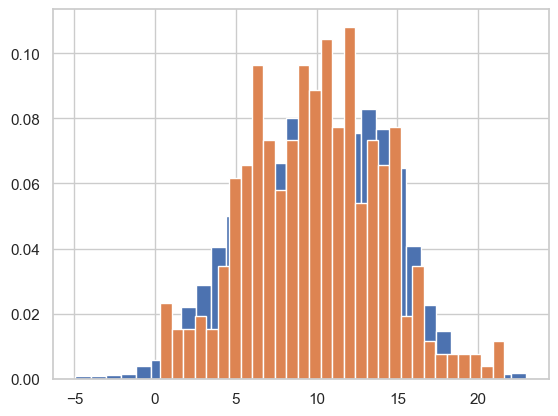

In [19]:
# Plotting the aggregated mean temperature data for Athenry 
no_bins = 30
n, bins_returned, patches = plt.hist(mydata_agg['Temp mean'], bins=no_bins, density=True);

bins = mean_bins(bins_returned)
# Get the mean and standard deviation of the data
mu = mydata_agg['Temp mean'].mean()
sigma = mydata_agg['Temp mean'].std()




temp_syn = np.random.normal(mu, sigma, size = 365)
plt.hist(temp_syn, bins=no_bins, density=True);
plt.show()



# Synthesising Relative Humidity Data

The daily mean relative humidity data is plotted below for the entire 8 year dataset. This dataset displays a left skew (the tail of the graph is to the left).
The log-normal distribution again appears to give a reasonable fit to the data as shown in the normalised pdf curvefit against the histogram of meteorological data.




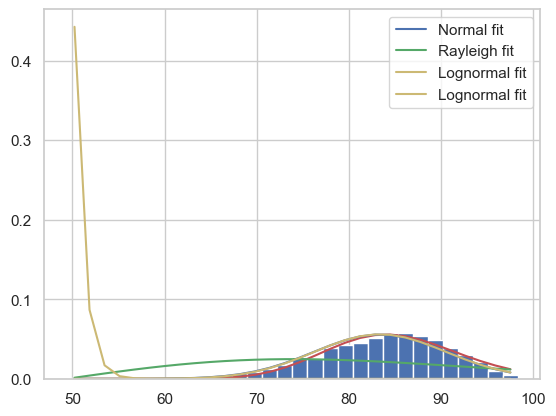

In [48]:
no_bins = 30
n, bins_returned, patches = plt.hist(mydata_agg['rhum mean'], bins=no_bins, density=True);
#rhum_syn = np.random.poisson(mydata_agg['rhum mean'].mean(), 2000)
#plt.hist(rhum_syn, bins=no_bins, density=True)

bins = mean_bins(bins_returned)
#bins = bins_returned

# returns mu and sigma in params 
params, extras = curve_fit(f_lognormal, bins, n)

mu_rhum = params[0]
sigma_rhum = params[1]
# fit a lognormal curve
pdf_lognormal = f_lognormal(bins, mu_rhum, sigma_rhum)
plt.plot(bins, pdf_lognormal, 'r')
#plt.show()

random_daily_rhum_1yr = np.random.default_rng().lognormal(mean=mu_rhum, sigma=sigma_rhum, size = len(mydata_agg))

#plt.hist(mydata_agg['rhum mean'], bins=no_bins);
#plt.hist(random_daily_rhum_1yr, bins=no_bins);

pop_size = 365
#https://stackoverflow.com/questions/71980083/specifiying-range-for-log-normal-distribution-in-python
# Want to exclude values over 100
#for sample in len(365):
#  random_daily_rhum_1yr = np.random.default_rng().lognormal(mean=mu_rhum, sigma=sigma_rhum, size = len(mydata_agg))



# https://glowingpython.blogspot.com/2012/07/distribution-fitting-with-scipy.html
from scipy.stats import norm, rayleigh, lognorm, multivariate_normal, expon
param = norm.fit(mydata_agg['rhum mean'])
pdf_fitted = norm.pdf(bins, loc=param[0], scale=param[1])
pdf = norm.pdf(bins)
plt.plot(bins, pdf_fitted, 'b-', label="Normal fit")



param = rayleigh.fit(mydata_agg['rhum mean'])
pdf_fitted_rayleigh = rayleigh.pdf(bins, loc=param[0], scale=param[1])
pdf = rayleigh.pdf(bins)
plt.plot(bins, pdf_fitted_rayleigh, 'g-', label="Rayleigh fit")



param = lognorm.fit(mydata_agg['rhum mean'])

#mean, var, skew, kurt = lognorm.fit(mydata_agg['rhum mean'])
pdf_fitted_lognorm = lognorm.pdf(bins, param[0], param[1], param[2])
#pdf = lognorm.pdf(bins)
plt.plot(bins, pdf_fitted_lognorm, 'y-', label="Lognormal fit")


# not relevant
param = expon.fit(mydata_agg['rhum mean'])

#mean, var, skew, kurt = lognorm.fit(mydata_agg['rhum mean'])
pdf_fitted_expon = expon.pdf(bins, param[0])
#pdf = lognorm.pdf(bins)
plt.plot(bins, pdf_fitted_expon, 'y-', label="Lognormal fit")
plt.legend()
plt.show()




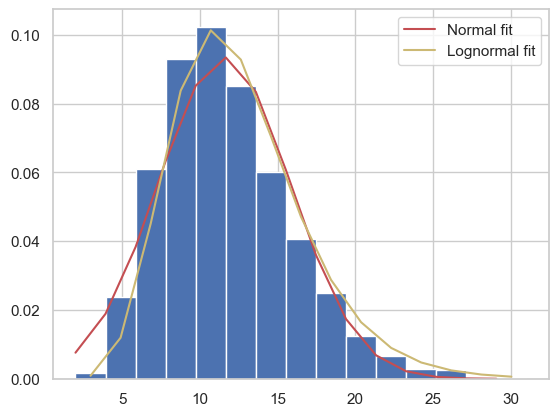

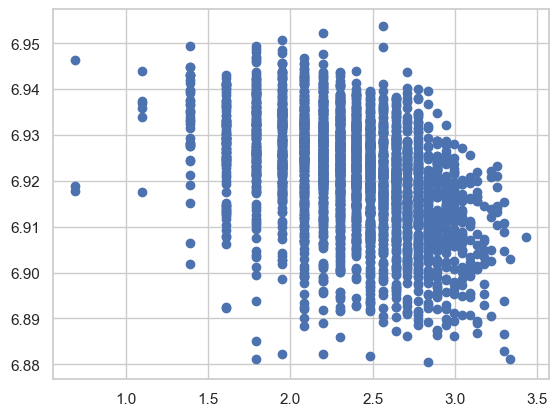

[[ 1. nan]
 [nan nan]]


In [43]:
n, bins_returned, patches = plt.hist(mydata_agg['wdsp max'], bins=15, density=True);

bins_mean = mean_bins(bins_returned)
bins = bins_returned[:-1]
param = norm.fit(mydata_agg['wdsp max'])
pdf_fitted = norm.pdf(bins, loc=param[0], scale=param[1])
pdf = norm.pdf(bins)
plt.plot(bins, pdf_fitted, 'r-', label="Normal fit")


param = lognorm.fit(mydata_agg['wdsp max'])

#mean, var, skew, kurt = lognorm.fit(mydata_agg['rhum mean'])
pdf_fitted_lognorm = lognorm.pdf(bins, param[0], param[1], param[2])
#pdf = lognorm.pdf(bins)
plt.plot(bins_mean, pdf_fitted_lognorm, 'y-', label="Lognormal fit")
plt.legend()
plt.show()

plt.scatter(mydata_agg_i['wdsp max'], mydata_agg_i['Msl mean']);
plt.show()

r = np.corrcoef(mydata_agg_i['wdsp max'], mydata_agg_i['Msl mean'])
print(r)

# References
[1] fitting distributions/picking distribution: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python/16651955#16651955
[1] https://docs.scipy.org/doc/scipy/reference/stats.html

- https://asaip.psu.edu/Articles/beware-the-kolmogorov-smirnov-test/

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html

- https://glowingpython.blogspot.com/2012/07/distribution-fitting-with-scipy.html

- Multivariate data fit: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html#scipy.stats.multivariate_normal

- Multivariate ranom data generation: https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html



